In [12]:
import numpy as np
from dataclasses import dataclass
from typing import Callable, Tuple, List, Dict
from scipy.optimize import minimize_scalar

# =========================
# 1) P4 true scenario value functions
# =========================

def v1(y: float) -> float:
    return -np.sqrt(abs(y))

def v2(y: float) -> float:
    return +np.sqrt(abs(y))

# probabilities
P1 = 0.5
P2 = 0.5


# =========================
# 2) WLSQ fit (quadratic) + exact global shift to make it an underestimator
# =========================

@dataclass
class QuadModel:
    a: float
    b: float
    c: float
    ms: float  # downward shift

    def q(self, y):
        return self.a * y * y + self.b * y + self.c

    def under(self, y):
        return self.q(y) + self.ms


def fit_weighted_quadratic(y: np.ndarray, f: np.ndarray, w: np.ndarray) -> Tuple[float, float, float]:
    """
    Fit q(y)=a y^2 + b y + c by weighted least squares.
    """
    assert y.ndim == f.ndim == w.ndim == 1
    X = np.vstack([y**2, y, np.ones_like(y)]).T
    W = np.sqrt(np.clip(w, 0.0, np.inf))  # sqrt weights
    Xw = X * W[:, None]
    fw = f * W
    coef, *_ = np.linalg.lstsq(Xw, fw, rcond=None)
    a, b, c = coef.tolist()
    return a, b, c


def exact_shift_to_underestimator(
    v: Callable[[float], float],
    a: float, b: float, c: float,
    Y: Tuple[float, float],
) -> float:
    """
    Compute ms = min_{y in Y} (v(y) - q(y)) exactly enough by 1D global search.
    Equivalent: ms = - max_{y in Y} (q(y) - v(y)).
    We split [-eps,0] and [0,eps] to handle non-smooth at 0.
    """
    lo, hi = Y
    assert lo <= 0 <= hi

    def q(y): return a*y*y + b*y + c
    def h(y): return q(y) - v(y)  # maximize this

    # candidate set includes endpoints and 0
    cand = [lo, 0.0, hi]
    best = max(h(y) for y in cand)

    # maximize on [lo, 0] and [0, hi] via minimizing -h
    # (minimize_scalar with bounded method is robust)
    for (L, U) in [(lo, 0.0), (0.0, hi)]:
        if U - L <= 0:
            continue

        res = minimize_scalar(lambda t: -h(t), bounds=(L, U), method="bounded")
        if res.success:
            best = max(best, h(res.x))

    ms = -best
    return ms


def build_wlsq_underestimator(
    v: Callable[[float], float],
    Y: Tuple[float, float],
    n_samples: int,
    rng: np.random.Generator,
    weight_mode: str = "uniform",
) -> QuadModel:
    """
    This is the ONLY place you need to replace if you want to call your existing WLSQ code.

    Current implementation:
      - sample y in Y
      - WLSQ quadratic fit
      - exact global shift to ensure underestimator on Y
    """
    lo, hi = Y
    # sample: always include endpoints + 0 to stabilize around cusp
    m = max(n_samples - 3, 0)
    ys_rand = rng.uniform(lo, hi, size=m) if m > 0 else np.array([])
    ys = np.concatenate([np.array([lo, 0.0, hi]), ys_rand])
    fs = np.array([v(float(t)) for t in ys])

    # weights
    if weight_mode == "uniform":
        w = np.ones_like(fs)
    elif weight_mode == "low_value_focus":
        # emphasize lower function values (more negative for v1)
        # stable monotone mapping to positive weights
        # For v1 (negative), exp(-alpha*f) increases weight near more negative values.
        alpha = 5.0
        w = np.exp(-alpha * (fs - fs.min()))
    elif weight_mode == "near_zero_focus":
        # emphasize near y=0 where non-Lipschitz happens
        sigma = 0.25 * (hi - lo)
        sigma = max(sigma, 1e-12)
        w = np.exp(-(ys**2) / (2.0 * sigma**2))
    else:
        raise ValueError(f"Unknown weight_mode={weight_mode}")

    a, b, c = fit_weighted_quadratic(ys, fs, w)
    ms = exact_shift_to_underestimator(v, a, b, c, Y)
    return QuadModel(a=a, b=b, c=c, ms=ms)


# =========================
# 3) Compute LB(Y) and Hausdorff error
# =========================

def min_of_quadratic_on_interval(a: float, b: float, c: float, lo: float, hi: float) -> float:
    """
    Minimize phi(y)=a y^2 + b y + c on [lo,hi].
    """
    vals = [a*lo*lo + b*lo + c, a*hi*hi + b*hi + c]
    if a > 0:
        ystar = -b / (2.0 * a)
        if lo <= ystar <= hi:
            vals.append(a*ystar*ystar + b*ystar + c)
    # if a<=0, minimum is at an endpoint in bounded interval
    return float(min(vals))


def hausdorff_error_for_interval(
    Y: Tuple[float, float],
    model1: QuadModel,
    model2: QuadModel,
) -> Tuple[float, float]:
    """
    Total relaxation: vhat(y) = 0.5*under1(y) + 0.5*under2(y) (quadratic).
    True min on Y: min v(y)=0.
    Error(Y) = 0 - min vhat(y) = -LB(Y).
    """
    lo, hi = Y

    # aggregated quadratic coefficients
    a = P1 * model1.a + P2 * model2.a
    b = P1 * model1.b + P2 * model2.b
    c = P1 * (model1.c + model1.ms) + P2 * (model2.c + model2.ms)

    lb = min_of_quadratic_on_interval(a, b, c, lo, hi)
    err = -lb  # since true min is 0
    return lb, err


# =========================
# 4) Run experiment + estimate order
# =========================

def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    """
    Fit log(y) = beta*log(x) + const.
    """
    assert np.all(x > 0) and np.all(y > 0)
    lx = np.log(x)
    ly = np.log(y)
    beta, _ = np.polyfit(lx, ly, deg=1)
    return float(beta)


def run_p4_experiment(
    eps0: float = 1.0,
    rho: float = 0.5,
    n_levels: int = 14,
    n_samples: int = 200,
    seed: int = 0,
    weight_mode: str = "uniform",
    slope_fit_last: int = 8,  # use last K points to estimate limiting slope
) -> Dict[str, np.ndarray]:
    rng = np.random.default_rng(seed)

    eps_list = []
    diam_list = []
    lb_list = []
    err_list = []

    for k in range(n_levels):
        eps = eps0 * (rho ** k)
        Y = (-eps, eps)

        m1 = build_wlsq_underestimator(v1, Y, n_samples=n_samples, rng=rng, weight_mode=weight_mode)
        m2 = build_wlsq_underestimator(v2, Y, n_samples=n_samples, rng=rng, weight_mode=weight_mode)

        lb, err = hausdorff_error_for_interval(Y, m1, m2)

        eps_list.append(eps)
        diam_list.append(2.0 * eps)
        lb_list.append(lb)
        err_list.append(err)

        print(f"k={k:02d}  eps={eps:.3e}  diam={2*eps:.3e}  LB={lb:.6e}  Err={err:.6e}")

    eps_arr = np.array(eps_list)
    diam_arr = np.array(diam_list)
    lb_arr = np.array(lb_list)
    err_arr = np.array(err_list)

    # slope on last points (small intervals)
    K = min(slope_fit_last, len(diam_arr))
    beta = estimate_slope_loglog(diam_arr[-K:], err_arr[-K:])

    print("\nEstimated Hausdorff convergence order (log-log slope on last points)")
    print(f"beta ≈ {beta:.4f}  (fit on last {K} intervals)\n")

    return {
        "eps": eps_arr,
        "diam": diam_arr,
        "lb": lb_arr,
        "err": err_arr,
        "beta": np.array([beta]),
    }


if __name__ == "__main__":
    # You can tune these:
    out = run_p4_experiment(
        eps0=1.0,
        rho=0.5,
        n_levels=14,
        n_samples=1500,
        seed=1,
        weight_mode="uniform",         # try: uniform / near_zero_focus / low_value_focus
        slope_fit_last=8,
    )


k=00  eps=1.000e+00  diam=2.000e+00  LB=-2.650923e-01  Err=2.650923e-01
k=01  eps=5.000e-01  diam=1.000e+00  LB=-1.876590e-01  Err=1.876590e-01
k=02  eps=2.500e-01  diam=5.000e-01  LB=-1.330352e-01  Err=1.330352e-01
k=03  eps=1.250e-01  diam=2.500e-01  LB=-9.559113e-02  Err=9.559113e-02
k=04  eps=6.250e-02  diam=1.250e-01  LB=-6.639255e-02  Err=6.639255e-02
k=05  eps=3.125e-02  diam=6.250e-02  LB=-4.732422e-02  Err=4.732422e-02
k=06  eps=1.562e-02  diam=3.125e-02  LB=-3.339454e-02  Err=3.339454e-02
k=07  eps=7.812e-03  diam=1.562e-02  LB=-2.351226e-02  Err=2.351226e-02
k=08  eps=3.906e-03  diam=7.812e-03  LB=-1.723997e-02  Err=1.723997e-02
k=09  eps=1.953e-03  diam=3.906e-03  LB=-1.211979e-02  Err=1.211979e-02
k=10  eps=9.766e-04  diam=1.953e-03  LB=-8.353963e-03  Err=8.353963e-03
k=11  eps=4.883e-04  diam=9.766e-04  LB=-6.052029e-03  Err=6.052029e-03
k=12  eps=2.441e-04  diam=4.883e-04  LB=-4.157496e-03  Err=4.157496e-03
k=13  eps=1.221e-04  diam=2.441e-04  LB=-2.985038e-03  Err=2.985

In [2]:
import numpy as np
from dataclasses import dataclass
from typing import Callable, Tuple, Dict
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# P4 true scenario value functions
def v1(y: float) -> float:
    return -np.sqrt(abs(y))

def v2(y: float) -> float:
    return +np.sqrt(abs(y))

P1 = 0.5
P2 = 0.5

@dataclass
class QuadModel:
    a: float
    b: float
    c: float
    ms: float  # downward shift

    def q(self, y):
        return self.a * y * y + self.b * y + self.c

    def under(self, y):
        return self.q(y) + self.ms

def fit_weighted_quadratic(y: np.ndarray, f: np.ndarray, w: np.ndarray):
    X = np.vstack([y**2, y, np.ones_like(y)]).T
    W = np.sqrt(np.clip(w, 0.0, np.inf))
    Xw = X * W[:, None]
    fw = f * W
    coef, *_ = np.linalg.lstsq(Xw, fw, rcond=None)
    return coef.tolist()  # a,b,c

def exact_shift_to_underestimator(v: Callable[[float], float], a: float, b: float, c: float, Y: Tuple[float, float]) -> float:
    lo, hi = Y
    assert lo <= 0 <= hi

    def q(y): return a*y*y + b*y + c
    def h(y): return q(y) - v(y)  # maximize

    cand = [lo, 0.0, hi]
    best = max(h(y) for y in cand)

    for (L, U) in [(lo, 0.0), (0.0, hi)]:
        if U - L <= 0:
            continue
        res = minimize_scalar(lambda t: -h(t), bounds=(L, U), method="bounded")
        if res.success:
            best = max(best, h(res.x))

    return -best  # ms

def build_wlsq_underestimator(v: Callable[[float], float], Y: Tuple[float, float], n_samples: int,
                             rng: np.random.Generator, weight_mode: str = "uniform") -> QuadModel:
    lo, hi = Y
    m = max(n_samples - 3, 0)
    ys_rand = rng.uniform(lo, hi, size=m) if m > 0 else np.array([])
    ys = np.concatenate([np.array([lo, 0.0, hi]), ys_rand])
    fs = np.array([v(float(t)) for t in ys])

    if weight_mode == "uniform":
        w = np.ones_like(fs)
    elif weight_mode == "near_zero_focus":
        sigma = 0.25 * (hi - lo)
        sigma = max(sigma, 1e-12)
        w = np.exp(-(ys**2) / (2.0 * sigma**2))
    elif weight_mode == "low_value_focus":
        alpha = 5.0
        w = np.exp(-alpha * (fs - fs.min()))
    else:
        raise ValueError(f"Unknown weight_mode={weight_mode}")

    a, b, c = fit_weighted_quadratic(ys, fs, w)
    ms = exact_shift_to_underestimator(v, a, b, c, Y)
    return QuadModel(a=a, b=b, c=c, ms=ms)

def min_of_quadratic_on_interval(a: float, b: float, c: float, lo: float, hi: float) -> float:
    vals = [a*lo*lo + b*lo + c, a*hi*hi + b*hi + c]
    if a > 0:
        ystar = -b / (2.0 * a)
        if lo <= ystar <= hi:
            vals.append(a*ystar*ystar + b*ystar + c)
    return float(min(vals))

def hausdorff_error_for_interval(Y: Tuple[float, float], model1: QuadModel, model2: QuadModel):
    lo, hi = Y
    a = P1 * model1.a + P2 * model2.a
    b = P1 * model1.b + P2 * model2.b
    c = P1 * (model1.c + model1.ms) + P2 * (model2.c + model2.ms)

    lb = min_of_quadratic_on_interval(a, b, c, lo, hi)
    err = -lb  # since true min is 0
    return lb, err

def estimate_slope_loglog(x: np.ndarray, y: np.ndarray) -> float:
    lx = np.log(x)
    ly = np.log(y)
    beta, _ = np.polyfit(lx, ly, deg=1)
    return float(beta)

def run_p4_experiment(eps0=1.0, rho=0.5, n_levels=14, n_samples=300, seed=1, weight_mode="uniform"):
    rng = np.random.default_rng(seed)

    eps_list, diam_list, lb_list, err_list = [], [], [], []
    for k in range(n_levels):
        eps = eps0 * (rho ** k)
        Y = (-eps, eps)

        m1 = build_wlsq_underestimator(v1, Y, n_samples=n_samples, rng=rng, weight_mode=weight_mode)
        m2 = build_wlsq_underestimator(v2, Y, n_samples=n_samples, rng=rng, weight_mode=weight_mode)

        lb, err = hausdorff_error_for_interval(Y, m1, m2)

        eps_list.append(eps)
        diam_list.append(2.0 * eps)
        lb_list.append(lb)
        err_list.append(err)

    return {
        "eps": np.array(eps_list),
        "diam": np.array(diam_list),
        "lb": np.array(lb_list),
        "err": np.array(err_list),
    }


In [3]:
out = run_p4_experiment(
    eps0=1.0,
    rho=0.5,
    n_levels=14,
    n_samples=300,
    seed=1,
    weight_mode="uniform",   # 也可以试 near_zero_focus / low_value_focus
)

out.keys(), out["diam"][:3], out["err"][:3]


(dict_keys(['eps', 'diam', 'lb', 'err']),
 array([2. , 1. , 0.5]),
 array([0.26578958, 0.19139861, 0.13962433]))

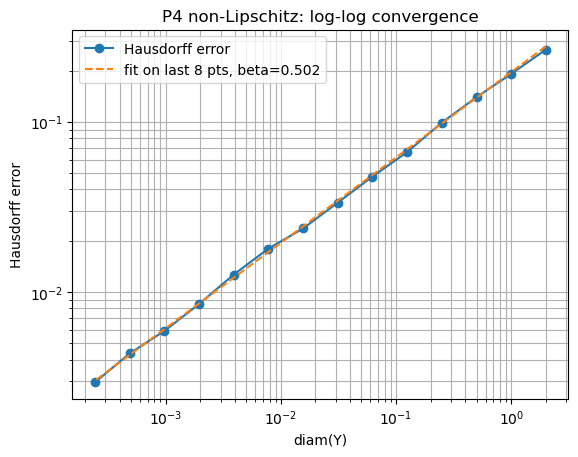

0.5021426994695731

In [4]:
diam = out["diam"]
err  = out["err"]

# 避免数值上出现 0 导致 log 崩
mask = (diam > 0) & (err > 0)
diam = diam[mask]
err  = err[mask]

K = 8  # 用最后 K 个点做 slope（你可以改）
K = min(K, len(diam))
beta = estimate_slope_loglog(diam[-K:], err[-K:])

# 拟合线：log(err)=beta*log(diam)+c
lx = np.log(diam[-K:])
ly = np.log(err[-K:])
c = float(np.mean(ly - beta * lx))
fit_err = np.exp(beta * np.log(diam) + c)

plt.figure()
plt.loglog(diam, err, marker='o', linestyle='-', label='Hausdorff error')
plt.loglog(diam, fit_err, linestyle='--', label=f'fit on last {K} pts, beta={beta:.3f}')
plt.xlabel('diam(Y)')
plt.ylabel('Hausdorff error')
plt.title('P4 non-Lipschitz: log-log convergence')
plt.grid(True, which='both')
plt.legend()
plt.show()

beta


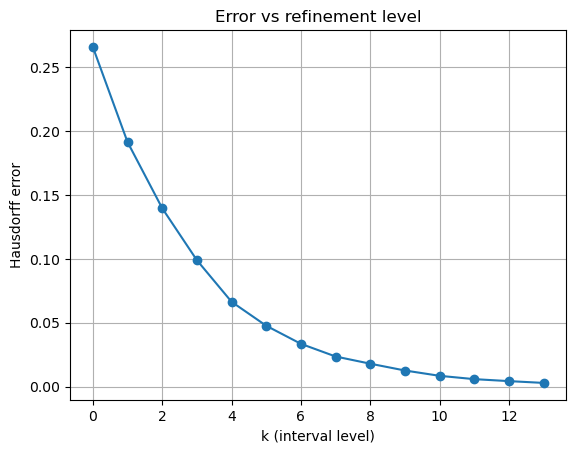

In [5]:
plt.figure()
plt.plot(np.arange(len(out["err"])), out["err"], marker='o')
plt.xlabel('k (interval level)')
plt.ylabel('Hausdorff error')
plt.title('Error vs refinement level')
plt.grid(True)
plt.show()
